In [1]:
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import eigsh
from tqdm import tqdm

import netket.operator as nkop
from netket.graph import Hypercube
from netket.hilbert import Spin
from netket.operator import Ising

import matplotlib.pyplot as plt

<Axes: >

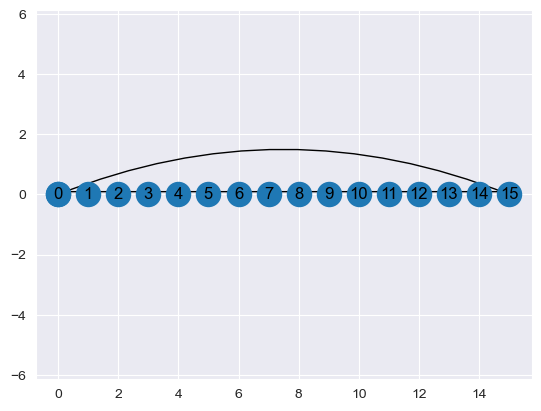

In [6]:
# set system parameters
CHAIN_LENGTH = 16
PERIODIC_BOUNDARIES = True
J_COUPLING = -1.0

#### DRAW GRAPH ####

graph = Hypercube(length=CHAIN_LENGTH, n_dim=1, pbc=PERIODIC_BOUNDARIES)
graph.draw()

In [7]:
hilbert = Spin(s=0.5, N=graph.n_nodes)

def tfim_hamiltonian(hilbert, graph, h, J):
    return Ising(hilbert, graph, h=h, J=J)

def get_ground_state(hamiltonian):
    sp_mat = hamiltonian.to_sparse()
    # k=1 gives ground state
    vals, vecs = eigsh(sp_mat, k=1, which="SA")
    psi = vecs[:, 0]

    # GAUGE FIXING:
    # rotate so the largest amplitude is Real and Positive
    # This is CRITICAL for the finite difference derivative to work!
    first_idx = np.argmax(np.abs(psi))
    phase = np.angle(psi[first_idx])
    psi = psi * np.exp(-1j * phase)

    return vals[0], psi

def compute_fidelity_susceptibility(h_center, delta_h=1e-5):
    """
    Computes chi_F using the Geometric Formula (Eq 4) and Finite Differences.
    """
    # 1. Get Ground States at h+delta and h-delta
    ham_plus  = tfim_hamiltonian(hilbert, graph, h=h_center + delta_h, J=J_COUPLING)
    ham_minus = tfim_hamiltonian(hilbert, graph, h=h_center - delta_h, J=J_COUPLING)
    ham_0     = tfim_hamiltonian(hilbert, graph, h=h_center, J=J_COUPLING)

    _, psi_plus  = get_ground_state(ham_plus)
    _, psi_minus = get_ground_state(ham_minus)
    _, psi_0     = get_ground_state(ham_0)

    # 2. Finite Difference Derivative (Central Difference)
    # |dPsi> approx (|Psi(h+d)> - |Psi(h-d)>) / 2d
    dpsi = (psi_plus - psi_minus) / (2 * delta_h)

    # 3. Geometric Formula for Susceptibility
    # chi_F = <dPsi|dPsi> - |<Psi|dPsi>|^2
    # (Assuming normalized states, so division by <Psi|Psi> is not needed)
    term1 = np.vdot(dpsi, dpsi).real
    term2 = np.abs(np.vdot(psi_0, dpsi))**2

    return term1 - term2

# Test on one point to check if it runs
test_h = 1.0
test_chi = compute_fidelity_susceptibility(test_h)
print(f"Test h={test_h}: Chi_F = {test_chi:.4f}")

Test h=1.0: Chi_F = 7.5000


In [8]:
print(f"{'='*60}")
print("CALCULATING FIDELITY SUSCEPTIBILITY")
print(f"System: TFIM (L={CHAIN_LENGTH}, PBC={PERIODIC_BOUNDARIES})")
print(f"{'='*60}")

# Define h-axis: Focus resolution around the critical point h=1.0
h_values = np.linspace(0.5, 1.5, 50)

chi_results = []

for h_val in tqdm(h_values):
    val = compute_fidelity_susceptibility(h_val, delta_h=1e-4)
    chi_results.append(val)

chi_results = np.array(chi_results)
print("\nCalculation Complete.")

CALCULATING FIDELITY SUSCEPTIBILITY
System: TFIM (L=16, PBC=True)


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


Calculation Complete.


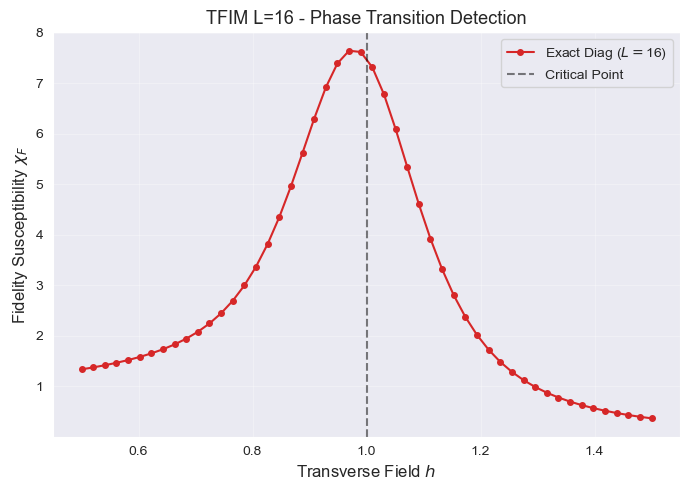

In [10]:
plt.figure(figsize=(7, 5), dpi=100)

plt.plot(h_values, chi_results, marker="o", markersize=4, linestyle="-", color="tab:red", label=f"Exact Diag ($L=${CHAIN_LENGTH})")

plt.xlabel(r"Transverse Field $h$", fontsize=12)
plt.ylabel(r"Fidelity Susceptibility $\chi_F$", fontsize=12)
plt.title(f"TFIM L={CHAIN_LENGTH} - Phase Transition Detection", fontsize=13)
plt.axvline(1.0, color="k", linestyle="--", alpha=0.5, label="Critical Point")

plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
data = np.column_stack((h_values, chi_results))

file_name = f"tfim_{CHAIN_LENGTH}_fidelity_ref.csv"
header = "h,chi_F"

np.savetxt(file_name, data, delimiter=",", header=header, comments="")
print(f"Reference data saved to: {file_name}")

Reference data saved to: tfim_16_fidelity_ref.csv
